Conda environment: https://github.com/hls-fpga-machine-learning/hls4ml-tutorial/blob/fpl2020/environment.yml

In [2]:
import tensorflow as tf

import pandas as pd
import numpy as np
import h5py

import hls4ml
from hls4ml.model.profiling import numerical

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [3]:
hf = h5py.File('processed_data_3classes.h5', 'r')

x_test = np.array(hf['x_test'])
y_test = np.array(hf['y_test'])

hf.close()

# Load model

In [4]:
model = tf.keras.models.load_model('model_3classes.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 10, 3)             12        
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 6)             78        
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 6)             24        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 6)             114       
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 6)             24        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 3)             57        
Total params: 309
Trainable params: 279
Non-trainable params: 30
_________________________________________________________

In [5]:
_ = model.evaluate(x_test, y_test)

20000/20000 [==============================] - 1s 67us/sample - loss: 0.1151 - accuracy: 0.9518


In [6]:
y_pred = model.predict(x_test)
y_pred[0]

array([[5.4688413e-02, 4.9434164e-01, 4.5096993e-01],
       [9.4530052e-01, 2.7788457e-02, 2.6911056e-02],
       [7.7923332e-08, 1.9496185e-06, 9.9999797e-01],
       [4.1503827e-06, 9.8861468e-01, 1.1381206e-02],
       [3.7428999e-05, 1.4778074e-03, 9.9848479e-01],
       [9.9953234e-01, 4.3940346e-04, 2.8298236e-05],
       [9.9647850e-01, 7.0935290e-04, 2.8121334e-03],
       [9.9924159e-01, 9.0691092e-12, 7.5837219e-04],
       [9.9999404e-01, 5.9805116e-06, 4.9824617e-08],
       [9.9959666e-01, 7.3130997e-07, 4.0263479e-04]], dtype=float32)

In [7]:
y_pred_class = np.argmax(y_pred, axis=2)
y_test_class = np.argmax(y_test, axis=2)

In [8]:
y_pred_class[:2]

array([[1, 0, 2, 1, 2, 0, 0, 0, 0, 0],
       [1, 1, 2, 1, 0, 0, 0, 0, 0, 0]])

In [9]:
y_test_class[:2]

array([[1, 0, 2, 1, 2, 0, 0, 0, 0, 0],
       [1, 1, 2, 1, 0, 0, 0, 0, 0, 0]])

## Config

In [10]:
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# trace outputs
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
    
    # increase precision
    if(type(config['LayerName'][layer]['Precision'])!=str):
        config['LayerName'][layer]['Precision']['result'] = 'ap_fixed<25,6>'

Interpreting Sequential
Topology:
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: conv1d, layer type: Conv1D
  -> Activation (relu), layer name: conv1d
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: conv1d_1, layer type: Conv1D
  -> Activation (relu), layer name: conv1d_1
Layer name: batch_normalization_2, layer type: BatchNormalization
Layer name: conv1d_2, layer type: Conv1D
  -> Activation (softmax), layer name: conv1d_2


In [11]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='hls4ml_prj',
                                                       fpga_part='xcku115-flvb2104-2-i')

Interpreting Sequential
Input shape: [10, 3]
Topology:
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 10, 3]]
Layer name: conv1d, layer type: Conv1D, current shape: [[None, 10, 3]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 10, 6]]
Layer name: conv1d_1, layer type: Conv1D, current shape: [[None, 10, 6]]
Layer name: batch_normalization_2, layer type: BatchNormalization, current shape: [[None, 10, 6]]
Layer name: conv1d_2, layer type: Conv1D, current shape: [[None, 10, 6]]
Creating HLS model


In [12]:
hls_model.compile()

Writing HLS project
Done


Profiling weights


/home/ubuntu/anaconda3/envs/hls4ml-env/lib/python3.7/site-packages/hls4ml/model/profiling.py:56: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=2)


Profiling activations
   batch_normalization
   conv1d
   batch_normalization_1
   conv1d_1
   batch_normalization_2
   conv1d_2


/home/ubuntu/anaconda3/envs/hls4ml-env/lib/python3.7/site-packages/hls4ml/model/profiling.py:56: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=2)


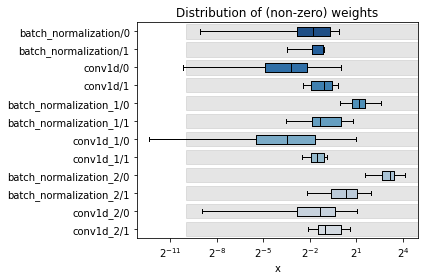

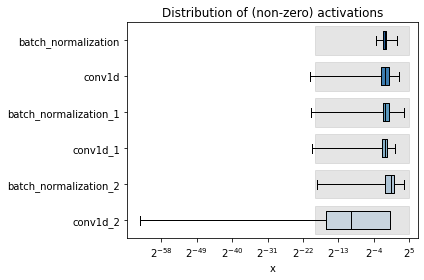

In [13]:
ap, wp = numerical(keras_model=model, hls_model=hls_model, X=x_test)
plt.show()

In [41]:
# weird output for softmax layer
hls_model.predict(x_test[:1])

array([ 0.00000000e+00,  9.76562500e-04,  9.76562500e-04,  6.15234375e-02,
        0.00000000e+00,  9.76562500e-04,  0.00000000e+00,  0.00000000e+00,
        3.22265625e-01,  0.00000000e+00, -1.54296875e-01,  3.51562500e-02,
        0.00000000e+00,  1.95312500e-03,  9.66796875e-01, -1.54296875e-01,
        1.95312500e-03,  0.00000000e+00,  2.14843750e-01,  0.00000000e+00,
        0.00000000e+00,  6.65039062e-01,  0.00000000e+00,  1.16601562e+00,
        4.96093750e-01,  0.00000000e+00,  0.00000000e+00,  6.64062500e-02,
        0.00000000e+00,  4.88281250e-03])

In [42]:
## different predict shape
print("Model prediction shape:", y_pred[0].shape)
print("HLS Model prediction shape:", hls_model.predict(x_test[:1]).shape)

Model prediction shape: (10, 3)
HLS Model prediction shape: (30,)


## Trace

In [16]:
hls4ml_pred, hls4ml_trace = hls_model.trace(x_test[:100])

Recompiling myproject with tracing
Writing HLS project
Done


In [17]:
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, x_test[:100])

Processing batch_normalization in Keras model...
Processing conv1d in Keras model...
Processing batch_normalization_1 in Keras model...
Processing conv1d_1 in Keras model...
Processing batch_normalization_2 in Keras model...
Processing conv1d_2 in Keras model...
Done taking outputs for Keras model.


In [18]:
hls4ml_trace.keys()

dict_keys(['batch_normalization', 'conv1d', 'conv1d_relu', 'batch_normalization_1', 'conv1d_1', 'conv1d_1_relu', 'batch_normalization_2', 'conv1d_2', 'conv1d_2_softmax'])

In [19]:
keras_trace.keys()

dict_keys(['batch_normalization', 'conv1d', 'conv1d_function', 'batch_normalization_1', 'conv1d_1', 'conv1d_1_function', 'batch_normalization_2', 'conv1d_2', 'conv1d_2_function'])

### Last convolution seems to be working

In [35]:
hls4ml_trace['conv1d_2'][0]

array([[ -2.48828125,  -2.10058594,  -1.94726562],
       [  1.77246094,  -5.96679688,  -2.13574219],
       [ -8.72753906,  -4.54589844,  11.20605469],
       [ -6.26074219,   6.63867188,   1.24902344],
       [ -6.05078125,  -1.36328125,   4.52832031],
       [  6.64453125,  -1.27734375,  -4.05957031],
       [  3.04492188,  -4.25      ,  -2.94628906],
       [ 11.97167969, -13.36523438,   4.71191406],
       [  9.24804688,  -2.68261719,  -7.16308594],
       [  6.99316406,  -7.14648438,  -0.69042969]])

In [34]:
keras_trace['conv1d_2'][0].numpy()

array([[ -3.5086858 ,  -1.3071108 ,  -1.398937  ],
       [ -0.08274388,  -3.609626  ,  -3.6417096 ],
       [ -7.320117  ,  -4.100454  ,   9.047421  ],
       [ -6.7545967 ,   5.626262  ,   1.1619208 ],
       [ -5.4662704 ,  -1.7904016 ,   4.725278  ],
       [  6.3958845 ,  -1.3337404 ,  -4.076359  ],
       [  3.0570216 ,  -4.190608  ,  -2.8132627 ],
       [ 11.961346  , -13.464044  ,   4.777768  ],
       [  9.45328   ,  -2.5737185 ,  -7.3614707 ],
       [  6.966608  ,  -7.161417  ,  -0.8504692 ]], dtype=float32)

### Weird behaviour in the activation layer

In [33]:
hls4ml_trace['conv1d_2_softmax'][0]

array([[ 0.00000000e+00,  9.76562500e-04,  9.76562500e-04],
       [ 6.15234375e-02,  0.00000000e+00,  9.76562500e-04],
       [ 0.00000000e+00,  0.00000000e+00,  3.22265625e-01],
       [ 0.00000000e+00, -1.54296875e-01,  3.51562500e-02],
       [ 0.00000000e+00,  1.95312500e-03,  9.66796875e-01],
       [-1.54296875e-01,  1.95312500e-03,  0.00000000e+00],
       [ 2.14843750e-01,  0.00000000e+00,  0.00000000e+00],
       [ 6.65039062e-01,  0.00000000e+00,  1.16601562e+00],
       [ 4.96093750e-01,  0.00000000e+00,  0.00000000e+00],
       [ 6.64062500e-02,  0.00000000e+00,  4.88281250e-03]])

In [32]:
keras_trace['conv1d_2_function'][0].numpy()

array([[5.4688413e-02, 4.9434164e-01, 4.5096993e-01],
       [9.4530052e-01, 2.7788457e-02, 2.6911056e-02],
       [7.7923332e-08, 1.9496185e-06, 9.9999797e-01],
       [4.1503827e-06, 9.8861468e-01, 1.1381206e-02],
       [3.7428999e-05, 1.4778074e-03, 9.9848479e-01],
       [9.9953234e-01, 4.3940346e-04, 2.8298236e-05],
       [9.9647850e-01, 7.0935290e-04, 2.8121334e-03],
       [9.9924159e-01, 9.0691092e-12, 7.5837219e-04],
       [9.9999404e-01, 5.9805116e-06, 4.9824617e-08],
       [9.9959666e-01, 7.3130997e-07, 4.0263479e-04]], dtype=float32)